In [2]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms as T
from matplotlib import pyplot as plt

In [37]:
train_dataset = datasets.SVHN(root='data', split='train', transform=T.ToTensor(), download=True)
test_dataset = datasets.SVHN(root='data', split='test', transform=T.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)


Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
def train(model, train_loader, optimizer, i_epoch, device):
  
  for i, (image, target) in enumerate(train_loader):
    image, target = image.to(device), target.to(device)
    output = model(image)
    
    loss = F.cross_entropy(output, target)

    model.zero_grad()
    loss.backward()
    optimizer.step()

In [6]:
def test(model, test_loader, i_epoch, device):
  accurate = 0 
  test_loss_list = []
  with torch.no_grad():
    for i, (image, target) in enumerate(test_loader):
      image,target = image.to(device), target.to(device)
      output = model(image)

      prediction = torch.argmax(output, dim=1)

      test_loss = F.cross_entropy(output, target)

      for p, t in zip(prediction, target):
        if p==t:
          accurate +=1
      test_loss_list.append(test_loss.detach().numpy())

  accuracy = accurate / len(test_loader.dataset)
  accuracy_value.append(accuracy)

  average_test_loss = sum(test_loss_list) / len(test_loss_list)
  test_loss_by_epoch.append(average_test_loss)
  print('epoch: {}, accuracy: {}, loss: {}'.format(i_epoch, accuracy, average_test_loss))

In [38]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(3,32,4,2,1),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,4,2,1),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,3,1,1),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,3,2,1),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,4,2,1),
        nn.Dropout(p=0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(2),
    )

    self.fc = nn.Sequential(
        nn.Linear(32,10),
        nn.Softmax()
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(-1,32)
    return self.fc(x)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


accuracy_value = []

CNN_model = CNN()
CNN_model.to(device)

CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.001)


for i_epoch in range(10):
  CNN_model.train()
  train(CNN_model, train_loader, CNN_optimizer, i_epoch, device)
  CNN_model.eval()
  test(CNN_model, test_loader, i_epoch, device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, accuracy: 0.5444837123540258, loss: 1.9132964844797171
epoch: 1, accuracy: 0.8234480639213276, loss: 1.6694780331031949
epoch: 2, accuracy: 0.8312077443146896, loss: 1.6389366388320923
epoch: 3, accuracy: 0.8493776889981561, loss: 1.6170364291060204
epoch: 4, accuracy: 0.865319606637984, loss: 1.5991896449350844
epoch: 5, accuracy: 0.8709280885064536, loss: 1.5939782787771786
epoch: 6, accuracy: 0.878841425937308, loss: 1.5842415889104207
epoch: 7, accuracy: 0.8805316533497234, loss: 1.58312009713229
epoch: 8, accuracy: 0.8699293177627535, loss: 1.5940937259617973
epoch: 9, accuracy: 0.8827980946527351, loss: 1.5804366165516424


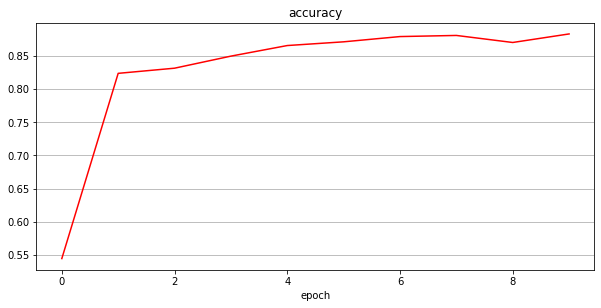

In [40]:
fig = plt.figure(figsize=(10,10))
accuracy_d = fig.add_subplot(2,1,2)

accuracy_d.plot(accuracy_value, color='red')
accuracy_d.grid(True, axis='y')
accuracy_d.set_title('accuracy')

plt.xlabel('epoch')
plt.show()